In [1]:
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt

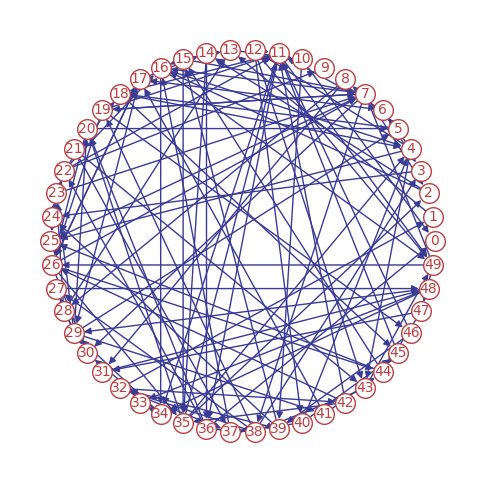

In [2]:
n = 50
p = 0.05

G = nx.fast_gnp_random_graph(n, p, directed=True)

plt.figure(figsize=(6,6))
plt.axis('equal')
options = {
            "node_color": "white",
            "edgecolors": "#b94042",
            "linewidths": 1,
            "node_size": 200,
            "edge_color": "#3a3b95",
            "font_size": 10,
            "font_color": '#b94042'
            }
nx.draw_circular(G, with_labels=True, **options)

In [3]:
def addEdgeAttribute(G) :
    strings = ["prefers to collaborate with", "prefers to socialize with", "avoids to collaborate with",
           "avoids to socialize with", "perceives that the node ? prefers to collaborate with him", 
           "perceives that the node ? prefers to socialize with him", 
           "perceives that the node ? avoids to collaborate with him", 
           "perceives that the node ? avoids to socialize with him"]
    
    def editString(s, node1, node2) :
        if "?" in s :
            return f"node {node1} {str(node2).join(s.split('?'))}"
        else :
            return f"node {node1} {s} node {node2}"

    for i, j in G.edges() :
        G[i][j]["opinion"] = editString(np.random.choice(strings), i, j)
        

In [4]:
addEdgeAttribute(G)

In [5]:
for u, v, data in G.edges(data=True):
    print(data["opinion"])

node 1 perceives that the node 13 prefers to collaborate with him
node 2 avoids to socialize with node 14
node 2 prefers to collaborate with node 16
node 3 prefers to socialize with node 24
node 4 perceives that the node 6 avoids to collaborate with him
node 4 perceives that the node 12 avoids to socialize with him
node 4 perceives that the node 25 prefers to socialize with him
node 4 prefers to socialize with node 43
node 5 perceives that the node 8 avoids to socialize with him
node 5 prefers to collaborate with node 18
node 6 prefers to socialize with node 11
node 6 prefers to collaborate with node 17
node 6 perceives that the node 3 avoids to collaborate with him
node 7 prefers to collaborate with node 16
node 7 avoids to socialize with node 19
node 7 perceives that the node 25 avoids to collaborate with him
node 7 perceives that the node 30 prefers to collaborate with him
node 7 perceives that the node 38 prefers to collaborate with him
node 7 perceives that the node 2 avoids to co

In [6]:
def saveGraphJson(G, path) :
    def convertToJSON(G) :
        nodes = [{"id": node} for node in G.nodes()]
        
        edges = [{
            "source": i,
            "target": j,
            "comment": data["opinion"]
        } for i, j, data in G.edges(data=True)]

        return {
            "nodes": nodes,
            "edges": edges
        }
    with open(path, "w") as write_file:
        json.dump(convertToJSON(G), write_file)


In [7]:
saveGraphJson(G, "./preferenceGraph.json")

In [8]:
import re

In [9]:
def info(G) :
    counts = [0]*8
    invalid = 0

    for i, j, data in G.edges(data=True) :
        if re.match(r".*perceives.*prefers.*collaborate.*", data["opinion"]) :
            counts[4] += 1
        elif re.match(r".*perceives.*prefers.*socialize.*", data["opinion"]) :
            counts[5] += 1
        elif re.match(r".*perceives.*avoids.*collaborate.*", data["opinion"]) :
            counts[6] += 1
        elif re.match(r".*perceives.*avoids.*socialize.*", data["opinion"]) :
            counts[7] += 1
        elif re.match(r".*prefers.*collaborate.*", data["opinion"]) :
            counts[0] += 1
        elif re.match(r".*prefers.*socialize.*", data["opinion"]) :
            counts[1] += 1
        elif re.match(r".*avoids.*collaborate.*", data["opinion"]) :
            counts[2] += 1
        elif re.match(r".*avoids.*socialize.*", data["opinion"]) :
            counts[3] += 1
        else :
            invalid += 1

    assert invalid == 0, "Invalid Attribute String != 0"

    labels = ["Name the members of your team\nyou mostly hang out with",
          "Name the members of your team\nyou less hang out with",
          "Name the members of your team that\nyou think they prefer to hang out with you",
          "Name the members of your team that\nyou think they do not prefer to hang out with you"]

    values = [sum(counts[i:i+2]) for i in range(0, 8, 2)]
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.show()
    

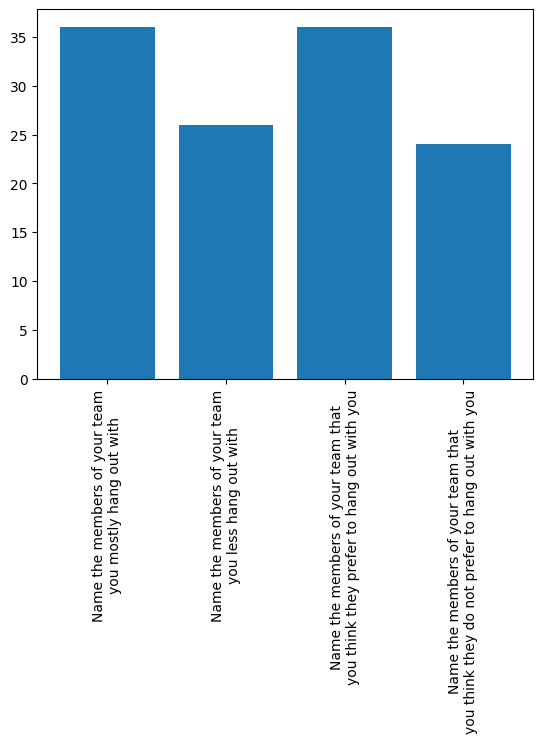

In [10]:
info(G)